In [59]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler,Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error

In [60]:
#loading the dataset
df= pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Feature selection

In [61]:
#checking and removing unwanted columns- area_type, availability, society, balcony
df= df.drop(['area_type', 'balcony', 'society', 'availability'], axis=1)
df.head()


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


handling missing values

In [62]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [63]:
#Handle missing values in Location column
df["location"].value_counts()  #count of houses in whitefield and Sarjapur Road are more, we can replce nan values with any of these locations
df["location"] = df["location"].fillna("Sarjapur  Road")
df["location"].value_counts()

location
Whitefield                         540
Sarjapur  Road                     400
Electronic City                    302
Kanakpura Road                     273
Thanisandra                        234
                                  ... 
3rd Stage Raja Rajeshwari Nagar      1
Chuchangatta Colony                  1
Electronic City Phase 1,             1
Chikbasavanapura                     1
Abshot Layout                        1
Name: count, Length: 1305, dtype: int64

In [64]:
df.isnull().sum()

location       0
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [65]:
#Handle missing values in size column
df["size"].value_counts() # most of the houses are 2 BHK 
df["size"] = df["size"].fillna("2 BHK")
df["size"].value_counts()

size
2 BHK         5215
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
10 BHK           2
11 Bedroom       2
27 BHK           1
19 BHK           1
43 Bedroom       1
16 BHK           1
14 BHK           1
12 Bedroom       1
13 BHK           1
18 Bedroom       1
Name: count, dtype: int64

In [66]:
df.isnull().sum()

location       0
size           0
total_sqft     0
bath          73
price          0
dtype: int64

In [67]:
#Handling nan values in Bath column
med_bath = df["bath"].median()
med_bath
df["bath"] = df["bath"].fillna(med_bath)
#since mean value gave floating point number

In [68]:
df["bath"] = df["bath"].astype(int)
df["bath"].unique()

array([ 2,  5,  3,  4,  6,  1,  9,  8,  7, 11, 10, 14, 27, 12, 16, 40, 15,
       13, 18])

In [69]:
#Drop duplicate rows
df.drop_duplicates(inplace=True)

Feature Engineering

In [70]:
df["location"].value_counts() #checking for outliers or inconsistent values or unrealistic data

location
Whitefield                              507
Sarjapur  Road                          365
Electronic City                         273
Thanisandra                             224
Kanakpura Road                          223
                                       ... 
Jogupalya                                 1
Subhash Nagar                             1
Kengeri Satellite Town KHB Apartment      1
Hanuman Nagar                             1
Chuchangatta Colony                       1
Name: count, Length: 1305, dtype: int64

In [71]:
#handling location column
df['location']= df['location'].apply(lambda x: x.strip()) #.apply() is used to map a single function to all the rows

loc= df['location'].value_counts() #storing the values of the column
loc_lthan_10 = loc[loc <= 10] #finding out the locations which has value count less than 10

df['location']= df['location'].apply(lambda x: 'others' if x in loc_lthan_10 else x) #here, all the values that are less than 10 for locations are merged into one single category or unique value so that the model is faster
df["location"].value_counts()

location
others                  2927
Whitefield               508
Sarjapur  Road           365
Electronic City          275
Thanisandra              226
                        ... 
Tindlu                    11
Banashankari Stage V      11
Doddakallasandra          11
Thyagaraja Nagar          11
HAL 2nd Stage             11
Name: count, Length: 232, dtype: int64

In [72]:
#handling size column
df['size'].value_counts() #has string type values while should be having numeric values, so we have remove the strings

out= [int(i.split()[0]) for i in df['size']]

df['bhk']= out
df


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5,120.00,4
2,Uttarahalli,3 BHK,1440,2,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3,95.00,3
4,Kothanur,2 BHK,1200,2,51.00,2
...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715,3,112.00,3
13315,Whitefield,5 Bedroom,3453,4,231.00,5
13316,others,4 BHK,3600,5,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2,60.00,2


In [73]:
#handling total_sqft column
#since it has some object type values like ranges, so we need convert that into numeric
#this func is about spliting those range type values, and 
def clean_sqft (sqft):
    li= sqft.split('-')
    try: 
        if len(li)==2:
            return float(li[0]) + float(li[1])/2
        else:
            return float(li[0])
    
    except: #if i get values like 1234- 
        return None
        
df['total_sqft'] = df['total_sqft'].apply(clean_sqft)

df["total_sqft"] = df["total_sqft"].fillna(round(df["total_sqft"].mean())) #rounded values so there are no float values for sqft

feature engineering

In [74]:
#create price_per_sqft
# formula:   price/total_sqft
df["price_per_sqft"] = df["price"]*100000/df["total_sqft"] #*100000 because the prices here are in lakhs, so for our calculation, we multiplied
df

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3,112.00,3,6530.612245
13315,Whitefield,5 Bedroom,3453.0,4,231.00,5,6689.834926
13316,others,4 BHK,3600.0,5,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2,60.00,2,5258.545136


handling outliers

In [75]:
#in total_sqft there are values like 1.000000 of sqft which is not normal, i.e,
# total_sqft/bhk => 300, which will be realistic
#In total_sqft column we have some rooms with less than 300 sqft those are outliers

df= df[df['total_sqft']/df['bhk']>=300]

In [76]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,11705.000000,11705.000000,11705.000000,11705.000000,11705.000000
mean,1628.246502,2.579667,114.455648,2.666809,6377.474059
std,1313.481400,1.099383,156.421987,0.995743,4291.202802
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1124.000000,2.000000,50.000000,2.000000,4207.119741
50%,1320.000000,2.000000,71.000000,3.000000,5326.086957
75%,1735.000000,3.000000,120.000000,3.000000,6989.247312
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [77]:
#handling outliers in bhk
df = df[df["bhk"]<=6] #keeping only the bhk where the value is 6

In [78]:
#Handling outliers in bath column
# bhk+2 - because we can have atleast 2 more bathrooms than the number of bedrooms

# It removes unrealistic rows where the number of bathrooms 
# (bath) is suspiciously high compared to the number of bedrooms (bhk).

df = df[df["bath"]<df["bhk"]+2]
df


,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715.0,3,112.00,3,6530.612245
13315,Whitefield,5 Bedroom,3453.0,4,231.00,5,6689.834926
13316,others,4 BHK,3600.0,5,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2,60.00,2,5258.545136


<Axes: xlabel='price_per_sqft'>

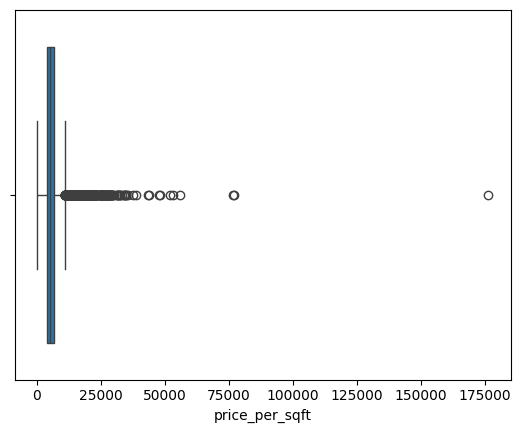

In [79]:
#Handling outliers in price per sqft
sns.boxplot(x="price_per_sqft",data=df)

<Axes: xlabel='price_per_sqft'>

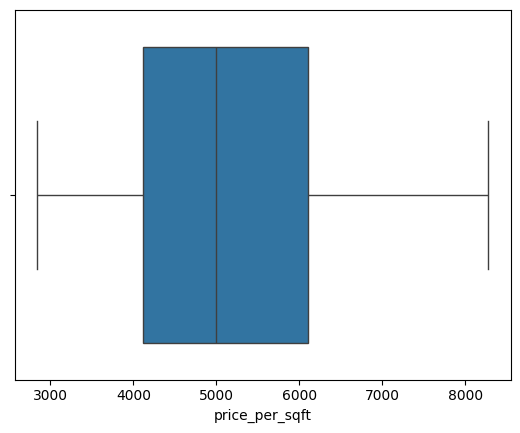

In [80]:
#IQR Method --> 
q1 = df["price_per_sqft"].quantile(0.25)
q3 = df["price_per_sqft"].quantile(0.75)

IQR = q3-q1

lower = q1-0.5*IQR  #0.5 is a standard value used, any value can be used
upper = q3+0.5*IQR

df = df[(df["price_per_sqft"]>=lower) & (df["price_per_sqft"]<=upper)]
sns.boxplot(x="price_per_sqft",data=df)

In [81]:
#after all the cleaning, our index value has been jumbled up
df.reset_index(inplace=True)
df

,index,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,0,Electronic City Phase II,2 BHK,1056.0,2,39.07,2,3699.810606
1,1,Chikka Tirupathi,4 Bedroom,2600.0,5,120.00,4,4615.384615
2,2,Uttarahalli,3 BHK,1440.0,2,62.00,3,4305.555556
3,3,Lingadheeranahalli,3 BHK,1521.0,3,95.00,3,6245.890861
4,4,Kothanur,2 BHK,1200.0,2,51.00,2,4250.000000
...,...,...,...,...,...,...,...,...
9429,13310,Rachenahalli,2 BHK,1050.0,2,52.71,2,5020.000000
9430,13312,Bellandur,2 BHK,1262.0,2,47.00,2,3724.247227
9431,13314,Green Glen Layout,3 BHK,1715.0,3,112.00,3,6530.612245
9432,13315,Whitefield,5 Bedroom,3453.0,4,231.00,5,6689.834926


In [82]:
#now, after all the cleaning, we can remove the price_per_sqft which was only created to clean the dataset, and the after resseting the index, the original index column can also be dropped
df = df.drop(["index","size","price_per_sqft"],axis=1)
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2,39.07,2
1,Chikka Tirupathi,2600.0,5,120.00,4
2,Uttarahalli,1440.0,2,62.00,3
3,Lingadheeranahalli,1521.0,3,95.00,3
4,Kothanur,1200.0,2,51.00,2
...,...,...,...,...,...
9429,Rachenahalli,1050.0,2,52.71,2
9430,Bellandur,1262.0,2,47.00,2
9431,Green Glen Layout,1715.0,3,112.00,3
9432,Whitefield,3453.0,4,231.00,5


Hence, now the data is ready to be used for training, before that we need to scale the model, select model, the algorithms and split the dataset.

Encoding

In [83]:
encoder = LabelEncoder()
df["encoded_loc"] = encoder.fit_transform(df["location"])
df.head()

,location,total_sqft,bath,price,bhk,encoded_loc
0,Electronic City Phase II,1056.0,2,39.07,2,75
1,Chikka Tirupathi,2600.0,5,120.00,4,57
2,Uttarahalli,1440.0,2,62.00,3,216
3,Lingadheeranahalli,1521.0,3,95.00,3,154
4,Kothanur,1200.0,2,51.00,2,146


In [84]:
#Divide into input and Output
X = df.drop(["location","price"],axis=1) #location because object column
y = df.price

In [85]:
#split the data into training and testing data
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
#model training using GridSearchCV to dynamically find the hyperparameters 
model = RandomForestRegressor(random_state=42)
params = {
    "n_estimators":[100,150,200,250,300],
    "max_depth":[3,4,5,6,7]
}

grid = GridSearchCV(estimator=model,param_grid=params,cv=5)

grid.fit(Xtrain,ytrain)

print("Best params: ",grid.best_params_)
print("Best Score: ",grid.best_score_)

In [ ]:
ypred = grid.predict(Xtest)
ypred

array([81.70811547, 62.48712229, 52.0802134 , ..., 87.74631532,
       87.5174548 , 46.21219355], shape=(2831,))

In [ ]:
print("Training Eff: ",grid.score(Xtrain,ytrain))
print("Testing Eff: ",grid.score(Xtest,ytest))

Training Eff:  0.8904543025268997
Testing Eff:  0.8097620540854027


In [ ]:
print("R2: ",r2_score(ytest,ypred))
print("MAE: ",mean_absolute_error(ytest,ypred))

R2:  0.8097620540854027
MAE:  14.875133190181195


In [ ]:
#Save cleaned dataset
df.to_csv("cleaned_df.csv")

In [ ]:
#Save the model in pickle file
import pickle
with open("RF_model.pkl","wb") as file:
    pickle.dump(grid,file)